In [73]:
import scipy.io
import numpy as np
from scipy import optimize
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']
del mat

mat = scipy.io.loadmat('ex4weights.mat') # Pre-trainned weight
theta1 = mat['Theta1']
theta2 = mat['Theta2']
del mat

Plot random 100 images

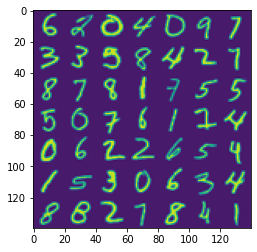

In [74]:
import matplotlib.pyplot as plt
def img_out(X_array,loc):
    return X_array[loc,:].reshape((20,-1)).T
plot_sqr = 7
img = np.zeros((plot_sqr*20,plot_sqr*20))
img_index = np.random.randint(0,high=X.shape[0],size=plot_sqr**2)
img_tmp = [X[i,:].reshape((20,-1)).T for i in img_index]
for i in range(plot_sqr):
    img[:,i*20:(i+1)*20,] =(np.array(img_tmp[i*plot_sqr:(i+1)*plot_sqr]).reshape((-1,20)))
plt.imshow(img)

Testing Forward Propagation 

In [139]:
def sigmoid(z):
    return (1/(1+np.e**(-z)))
bias = np.ones(y.flatten().shape)
a1 = np.c_[bias,X].T  # shape = (banyak gambar x param)
z2 = theta1 @ a1
a2 = np.c_[bias,sigmoid(z2.T)].T # shape = (banyak gambar x param)
z3 = theta2 @ a2
a3 = sigmoid(z3)

Change output format

In [102]:
#plt.imshow(img_out(X,0))
y_a = np.zeros((10,5000)).astype('int32')
y_temp = np.where(y==10,0,y)
for i in range(5000):
    y_a[y_temp[i],i] = 1
y_a = np.r_[y_a[1:,:], y_a[0,:].reshape(1,-1)]

Testing cost

In [152]:
J1 = np.sum(-np.multiply(y_a,np.log(a3)) - np.multiply((1-y_a),np.log(1-a3)))/5000
lamb = 1
J2 = (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:]))) * lamb/10000
cost = J1 +J2
print(f'Cost w/o regularized is {J1:.6f}, expected value of 0.287629')
print(f'Cost w/  regularized is {cost:.6f}, expected value of 0.383770')

Cost w/o regularized is 0.287629, expected value of 0.287629
Cost w/  regularized is 0.383770, expected value of 0.383770


Create cost function and sigmoid gradient

In [229]:
def flattentheta(theta_1,theta_2):
    return np.r_[theta_1.flatten(),theta_2.flatten()]
    
def unflattentheta(thetax,t1s,t2s):
    sep = t1s[0] * t1s[1]
    th1 = thetax[:sep].reshape(t1s)
    th2 = thetax[sep:].reshape(t2s)
    return th1,th2

def forward_prop(m,X,th1,th2):
    bias = np.ones(m)
    a1 = np.c_[bias,X].T  # shape = (banyak gambar x param)
    z2 = th1 @ a1
    a2 = np.c_[bias,sigmoid(z2.T)].T # shape = (banyak gambar x param)
    z3 = th2 @ a2
    a3 = sigmoid(z3)
    return a1,z2,a2,z3,a3
    
thetax = flattentheta(theta1,theta2)
theta1shape = theta1.shape
theta2shape = theta2.shape

def J(theta,X,y,t1s,t2s,lambd=0):
    m = X.shape[0]
    th1,th2 = unflattentheta(theta,t1s,t2s)
    _,_,_,_,a3 = forward_prop(m,X,th1,th2)
    J1 = np.sum(-np.multiply(y,np.log(a3)) - np.multiply((1-y),np.log(1-a3)))/m
    J2 = (np.sum(np.square(th1[:,1:])) + np.sum(np.square(th2[:,1:]))) * lambd/(2*m)
    return J1 + J2

def siggrad(z):
    return sigmoid(z)*(1-sigmoid(z)) 


Randomize init param

In [171]:
eps = 0.12
def randomtheta(ep,t1s,t2s):
    length = t1s[0] * t1s[1] + t2s[0] * t2s[1]
    return np.random.rand(length,)*2*ep -ep
    
theta_init = randomtheta(eps,theta1shape,theta2shape)

Testing backpropagtion

In [226]:
m = 5000
a1,z2,a2,z3,a3 = forward_prop(bias,X,theta1,theta2)
lambd = 1
dk3 = a3-y_a
dk2 = theta2[:,1:].T @ dk3 * siggrad(z2)
Delta = dk2 @ a1.T
Delta2 = dk3 @ a2.T
print(Delta.shape, Delta2.shape)
Delta[:,1:] = (Delta[:,1:] + lambd * theta1[:,1:])/m
Delta2[:,1:] = (Delta2[:,1:] + lambd * theta2[:,1:])/m

(25, 401) (10, 26)


Gradient regularized neural network

In [255]:
def gradJ(theta,X,y,t1s,t2s,lambd=0):
    m = X.shape[0]
    th1,th2 = unflattentheta(theta,t1s,t2s)
    a1,z2,a2,z3,a3 = forward_prop(m,X,th1,th2)
    dk3 = a3-y
    dk2 = theta2[:,1:].T @ dk3 * siggrad(z2)
    Delta = dk2 @ a1.T
    Delta2 = dk3 @ a2.T
    Delta[:,1:] = (Delta[:,1:] + lambd * theta1[:,1:])/m
    Delta2[:,1:] = (Delta2[:,1:] + lambd * theta2[:,1:])/m
    return flattentheta(Delta,Delta2)
a = gradJ(thetax,X,y_a,theta1shape,theta2shape)

In [256]:
a.shape

(10285,)

In [271]:
theta_init = randomtheta(eps,theta1shape,theta2shape)
optimizer = optimize.minimize(fun=J, x0=theta_init,args=(X,y_a,theta1shape,theta2shape,1), method ='Newton-CG', jac=gradJ)


In [272]:
optimizer

     fun: 7.040949022245526
     jac: array([-1.99032039e+03, -2.11248326e-12,  4.38829369e-13, ...,
        2.25742919e-01,  2.43436200e-01,  2.15612538e-01])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 27
    nhev: 0
     nit: 0
    njev: 16
  status: 2
 success: False
       x: array([-0.11157952, -0.05403312,  0.08492353, ..., -0.05632202,
        0.07900109,  0.07539422])